# The DeLong - Shiller Redux

I was 21 when I graduated from university and started my first full-time job. One benefit offered by my employer was a 401(k) with matching contributions. At the time, I was not thinking much about planning for retirement, but everyone told me I should take advantage and invest at least the matched amount, so I followed this advice. As I tried to structure my portfolio, I was faced with a dilemma: on the one hand, I knew that the younger you are, the more you should invest in stocks, but on the other hand, Alan Greenspan had recently given his "irrational exuberance" speech. Should I ignore the Chairman of the Federal Reserve's admonition and invest in stocks anyway, or was there a more prudent strategy?

While considering the options, I remembered the efficient-market hypothesis, which had come up as a casual aside by one of my mathematics professors in college. I did not even think to know what exactly it meant, but I took it to imply that it is not possible to time the stock market. That for me was the conclusive rationalization that convinced me to ignore Greenspan and build a stock-heavy portfolio.

Fast-forward 20 years later to today. My first foray into investing turned out to be somewhat of a roller-coaster ride: the value of my 401(k) portfolio did initially go up, but then was in the red for a period of time before eventually returning to positive territory. Given my conundrum in planning my initial investment, I've never stopped wondering if I could not have achieved better returns, not to mention a smoother ride, if I had paid more attention to Greenspan. But since I knew almost nothing about economics or finance, I had no idea how to investigate this question.

Then, in the summer of 2014, Robert Shiller and Brad DeLong had a public discussion which delved into exactly the issues that were relevant to me as I struggled with my 401(k). Nobel Laureate Robert Shiller, who participated in coining the phrase *[irrational exuberance](https://en.wikipedia.org/wiki/Irrational_exuberance)*, argued in an  [Upshot article in the New York Times](http://www.nytimes.com/2014/08/17/upshot/the-mystery-of-lofty-elevations.html?_r=0) that there is a way to measure if stocks are relatively expensive: the cyclically adjusted price-earnings, or CAPE, ratio. Furthermore, he claims, if the value of this ratio is above 25, a major market drop is probably brewing.

Further insight came from Brad DeLong, [who blogged a response](http://delong.typepad.com/sdj/2014/08/under-what-circumstances-should-you-worry-that-the-stock-market-is-too-high-the-honest-broker-for-the-week-of-august-16.html). In formulating his response, he provides a clear interpretation of what CAPE measures and offers historical context and additional tools for interpreting and analyzing stock price movements. His article, written in 2014, begins by looking at the most recent peak of the CAPE ratio, which was then in 2007. He writes, "...we find that we cannot calculate a ten-year return for the 2007 CAPE peak of 27.54--we still have three years to go." Those three years have in the meantime transpired, and we now have the data necessary to calculate the ten-year return for May 2007, when the aforementioned peak occurred. This seems like a good time to revisit the DeLong-Shiller argument.

# Caveats

In case it is not yet obvious, let me come out and say that I know nothing about economics, nothing about finance, and nothing about investing. I'm just a data scientist with some time on my hands who had is interest piqued. This article should not be construed as any kind of financial advice.

If you are interested in seeing how I arrived at my results, all of my code is available on [github](https://github.com/ciyer/stockscape/blob/master/analysis/jupyter/DeLong-Shiller-Redux.ipynb). If you have any comments or questions, I would love to hear them [twitter:@ciyer](https://twitter.com/ciyer).

In [1]:
# Imports, set up, etc.
import pandas as pd
import numpy as np
import scipy
import os
import os.path
from matplotlib import cm
from IPython.display import display, HTML

import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import stockscape as s_cape
from stockscape import dsr
    
# Styling
style_prefs = dsr.DsrStylePrefs()
style_prefs.use()

/Users/ciyer/Applications/miniconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


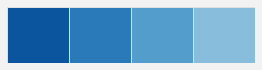

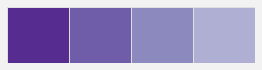

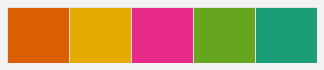

In [2]:
# Show the color palettes used
s_palette = style_prefs.s_palette
b_palette = style_prefs.b_palette
l_palette = style_prefs.l_palette
sns.palplot(style_prefs.s_palette)
sns.palplot(style_prefs.b_palette)
sns.palplot(style_prefs.l_palette)

# Read in Data

In [3]:
ie_data = s_cape.read_ie_data("../../data/ie_data.xls")
cape_10y = s_cape.Cape(ie_data, 10)
stocks_10y = s_cape.StockReturns(ie_data, 10)
wr_10y = s_cape.WarrantedReturns(cape_10y, stocks_10y)
bond_10y = s_cape.BondHoldToMaturityReturns(ie_data)
inflation_10y = s_cape.Inflation(ie_data, 10)
df_10y = cape_10y.df.join(stocks_10y.df).join(wr_10y.df).join(bond_10y.df).join(inflation_10y.df)
latest_10y_data_date = df_10y['returns'].dropna().index[-1]
df_10y.head()

,dividend,earnings,price,m_return,cape,gross_returns,returns,gross_warranted_returns,gross_wr_error,warranted_returns,wr_error,gross_gs10_returns,gs10_returns,forward_inflation
date_dt,,,,,,,,,,,,,,
1871-01-01,5.132988,7.896904,87.655639,NaN,NaN,2.412920,0.130609,NaN,NaN,NaN,NaN,1.221999,0.083115,-0.027619
1871-02-01,4.980900,7.662923,86.207886,-0.011781,NaN,2.420445,0.130858,NaN,NaN,NaN,NaN,1.267661,0.085320,-0.029564
1871-03-01,4.908171,7.551033,87.025653,0.014230,NaN,2.423240,0.130951,NaN,NaN,NaN,NaN,1.301991,0.086952,-0.030991
1871-04-01,5.094094,7.837067,92.869245,0.072026,NaN,2.163337,0.122056,NaN,NaN,NaN,NaN,1.196723,0.081876,-0.026413
1871-05-01,5.212552,8.019310,97.434617,0.053836,NaN,2.179785,0.122638,NaN,NaN,NaN,NaN,1.168942,0.080500,-0.025143


# DeLong Framework

To start, let us retrace the discussion from 2014. [Shiller's article](http://www.nytimes.com/2014/08/17/upshot/the-mystery-of-lofty-elevations.html?_r=0) focuses on the CAPE ratio as a signal for reading future price movements in the stock market. Throughout the 20th century, CAPE has averaged around 15, and when it has gone above or below this level, it has  eventually reverted to the historical mean. Shiller believes that a persistently high CAPE ratio is especially worrying if there is no good explanation for why stocks are so coveted, and finds that this was the case in 2014. Though he stresses that CAPE cannot be used to time the market, CAPE has been above 25 only three times since 1881, and each time a crash has followed not long after.

[DeLong](http://delong.typepad.com/sdj/2014/08/under-what-circumstances-should-you-worry-that-the-stock-market-is-too-high-the-honest-broker-for-the-week-of-august-16.html) takes Shiller's argument and builds a quantitive framework to evaluate it. What does it mean to say, "stocks are expensive?": it means that expected returns are poor. (Note: monetary values discussed in this post are always in real terms and returns and inflation are always forward real returns and forward inflation, even if not so qualified.) Is there a link between the CAPE ratio and expected returns? DeLong points out that there is a natural connection if the efficient-market hypothesis is assumed. In this case, for the purpose of estimating return, one can think of earnings as being re-invested in the market, meaning that the expected return on the stock market should be equal to earnings/price. Earnings/price can, in turn, be estimated as 1/CAPE. He calls the EMH-expected-returns for a given value of CAPE "warranted returns", and to visualize his framework, DeLong constructs the following plot, which I've updated to include the latest data.

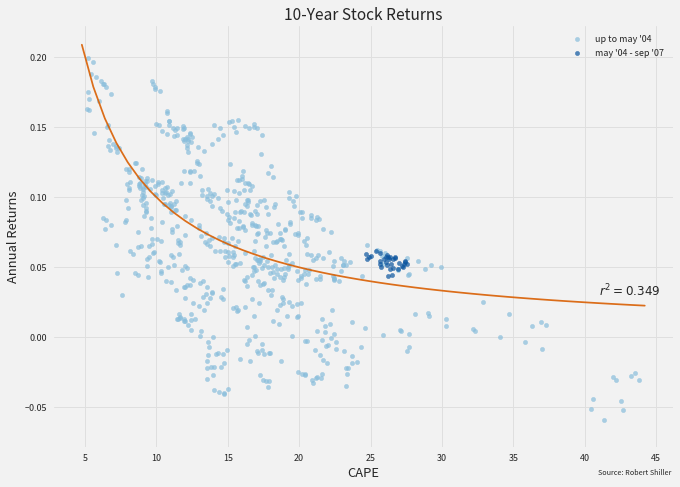

In [4]:
cape_range, wr = wr_10y.warranted_returns_curve()
fig, ax = plt.subplots()
to_delong, since_delong = dsr.split_to_and_since_delong(df_10y)
to_delong.plot.scatter('cape', 'returns', alpha=0.7, color=s_palette[3], ax=ax, 
                       label="up to {}".format(dsr.latest_index_label(to_delong)))
latest_date_str = "aug '04 - {}".format(latest_10y_data_date.strftime("%b '%y").lower())
since_delong.plot.scatter('cape', 'returns', alpha=0.7, color=s_palette[0], ax=ax, 
                          label="{} - {}".format(dsr.latest_index_label(to_delong), dsr.latest_index_label(since_delong)))

ss_res = np.sum(np.power(df_10y['wr_error'], 2))
ss_tot = np.sum(np.power(df_10y['returns'] - df_10y['returns'].mean(), 2))
rsquared = 1 - (ss_res / ss_tot)
ax.text(cape_range[-5], wr[-5]+0.005, "$r^2={:.3f}$".format(rsquared))

ax.set_ylabel("Annual Returns")
ax.set_xlabel("CAPE")
ax.set_title("10-Year Stock Returns")
plt.plot(cape_range, wr, color=l_palette[0],  alpha=0.9)
dsr.cite_source(ax)

This plot shows CAPE vs. 10-year returns and includes a curve to indicate the warranted returns. Reflecting on the fit of the curve, DeLong remarks, "Given the naiveté of the framework, that turns out to be [...] a remarkably good guide to the central tendency of the distribution of future ten-year returns conditional on the CAPE." And I would have to agree, as evidenced by this plot of the framework error.

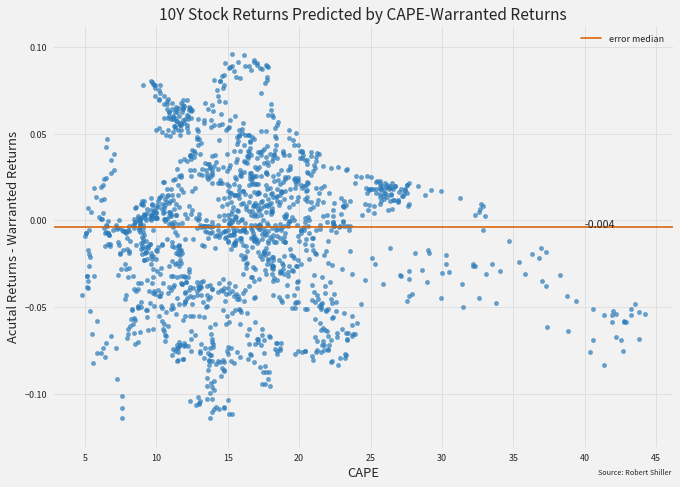

In [5]:
ax = df_10y.plot.scatter('cape', 'wr_error', alpha=0.7, color=s_palette[1])
ax.axhline(df_10y['wr_error'].median(), alpha=0.9, color=l_palette[0], label='error median')
ax.text(40, df_10y['wr_error'].median(), "{:.3f}".format(df_10y['wr_error'].median()))
ax.set_ylabel("Acutal Returns - Warranted Returns")
ax.set_xlabel("CAPE")
ax.set_title("10Y Stock Returns Predicted by CAPE-Warranted Returns")
ax.legend()
dsr.cite_source(ax)

DeLong takes issue with the CAPE >= 25 threshold. Looking at the plot of CAPE vs. 10-year returns, you do not get the sense that returns take a sudden nosedive beyond CAPE = 25: at CAPE above 25, most of the points are still above the _returns = 0_ line, meaning that they generate positive **real** returns, and many are even above the warranted returns curve. Beyond this, there are many cases of negative real returns for CAPE < 25 as well. DeLong devotes his attention to probing these questions.

Personally, I am also uneasy with the CAPE >= 25 threshold, but my uneasiness derives more from the rarity of that situation. There have only been three periods from which to draw upon, and within each period, the economic forces that influence returns are going to be highly correlated.

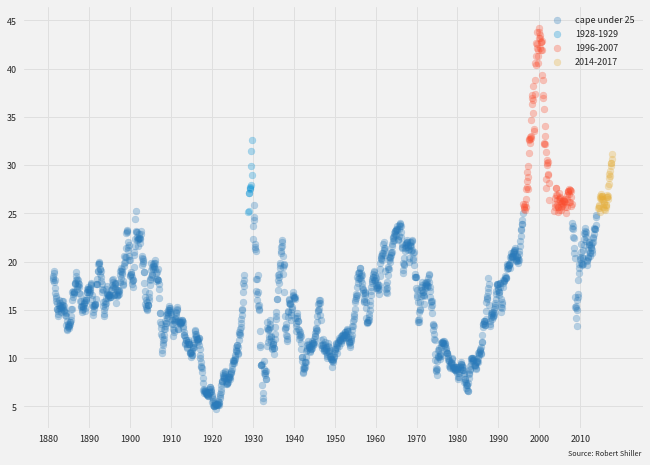

In [6]:
high_cape, under_25 = dsr.split_cape_threshold_years(df_10y, 25)
plt.scatter(under_25.index, under_25['cape'], alpha=0.3, color=s_palette[1], label="cape under 25")
sns.set_palette(l_palette[2:])
for name, group_df in high_cape.groupby('period'):
    plt.scatter(group_df.index, group_df['cape'], alpha=0.3, label=name)
plt.xticks(dsr.time_ticks())
plt.legend()
dsr.cite_source(plt.gca())

The threshold itself, though, is somewhat beside the point. My own interest is not so much the threshold; rather it is determining if CAPE offers insight for making investment decisions. For a given CAPE, are the expected returns good in stocks, or is it better to look elsewhere for investment opportunities? Robert Shiller generously makes his data available (and keeps it updated!) here: http://www.econ.yale.edu/~shiller/data/ie_data.xls, allowing us to look for answers to our own questions. This Excel file is the sole data source used in this article.

# Stocks vs. Bonds

Instead of focusing solely on 10-year investments in stocks, as Shiller and DeLong do, I'm interested in comparing investment vehicles and seeing if CAPE is a helpful tool for choosing among them. Can CAPE be used to decide if bonds are presently a more attractive investment than stocks? And there are further questions even when just looking at stocks. CAPE seems to have some explanatory power over a 10-year investment horizon, but what about other horizons like 15 or 20 years? Is it equally good then? 

Let us start by considering the choice of instrument: stocks vs. bonds. Shiller's data does not include real returns for anything other than stocks, but it does include nominal yields on 10-year U.S. Treasury bonds. If we assume that the bonds are bought at par and held until maturity, we can compute the annualized 10-year forward real return on bonds.

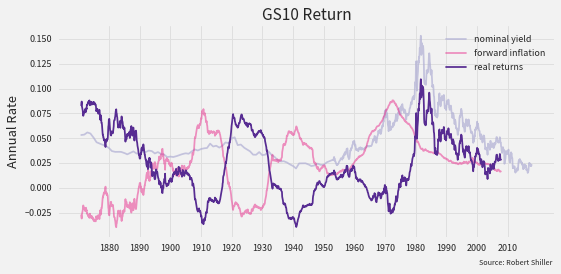

In [7]:
gs10_s = ie_data.nominal_data.gs10_s
plt.figure(figsize=style_prefs.figure_small_size)
plt.plot(gs10_s.index, gs10_s, color=b_palette[3], alpha=0.7, label='nominal yield')
plt.plot(df_10y.index, df_10y['forward_inflation'], color=l_palette[2], alpha=0.5, label='forward inflation')
plt.plot(df_10y.index, df_10y['gs10_returns'], color=b_palette[0], label='real returns')
plt.xticks(dsr.time_ticks())
plt.ylabel("Annual Rate")
plt.title("GS10 Return")
plt.legend()
dsr.cite_source(plt.gca())

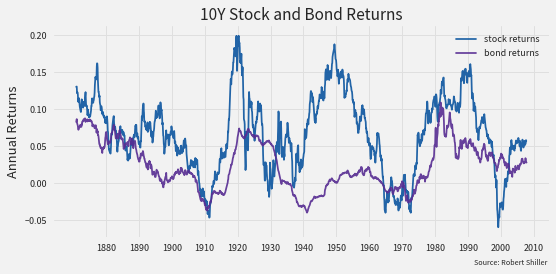

In [8]:
fig, ax = plt.subplots(figsize=style_prefs.figure_small_size)
ax.plot(df_10y.index, df_10y['returns'], alpha=0.9, color=s_palette[0], label="stock returns")
ax.plot(df_10y.index, df_10y['gs10_returns'], alpha=0.9, color=b_palette[0], label="bond returns")
ax.xaxis.set_ticks(dsr.time_ticks())
ax.set_ylabel("Annual Returns")
ax.set_title("10Y Stock and Bond Returns")
ax.legend()
dsr.cite_source(ax)

Compared to stock returns as a time series (above), we see that stocks usually have higher 10-year returns than bonds, but bonds do occasionally perform better than stocks. To see if CAPE plays a role, let's look at investment performance against CAPE.

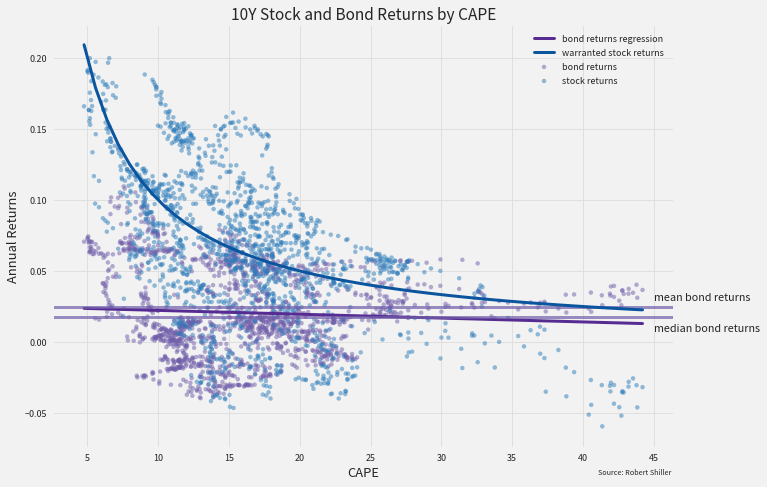

In [9]:
ax = df_10y.plot.scatter('cape', 'gs10_returns', edgecolor='none', alpha=0.5, color=b_palette[1], label='bond returns')
lm = dsr.LinearModel('cape', 'gs10_returns', df_10y, [cape_range[0], cape_range[-1]]).fit_and_predict()
ax.plot(lm.pred_range, lm.predictions, color=b_palette[0],  lw=3, label='bond returns regression')
ax.axhline(df_10y['gs10_returns'].mean(), alpha=0.7, color=b_palette[1], lw=3)
ax.text(45, df_10y['gs10_returns'].mean() + 0.005, "mean bond returns")
ax.axhline(df_10y['gs10_returns'].median(), alpha=0.7, color=b_palette[1], lw=3)
ax.text(45, df_10y['gs10_returns'].median() - 0.01, "median bond returns")

df_10y.plot.scatter('cape', 'returns', edgecolor='none', alpha=0.5, color=s_palette[1], label='stock returns', ax=ax)
cape_range, wr = wr_10y.warranted_returns_curve()
ax.plot(cape_range, wr, color=s_palette[0],  alpha=1.0, lw=3, label='warranted stock returns')

ax.set_ylabel("Annual Returns")
ax.set_xlabel("CAPE")
ax.set_title("10Y Stock and Bond Returns by CAPE")
ax.legend()
dsr.cite_source(ax)

Visually, there does seem to be a relationship between CAPE and the relative performance of stocks vs. bonds. 

Since 1881, the mean and median real yield on 10-year bonds has been around 2% (2.4%, and 1.8%, respectively). If we use a theoretical model in which stocks generate returns according to the warranted returns for a given CAPE and bonds generate 2.4% returns across the CAPE spectrum, stocks should basically always outperform bonds over 10 years. The mean bond returns do cross the warranted returns curve, but only at very highest values for CAPE, levels that have only been seen once in the last 135 years.

But this does not seem to actually be the case in the historical data.

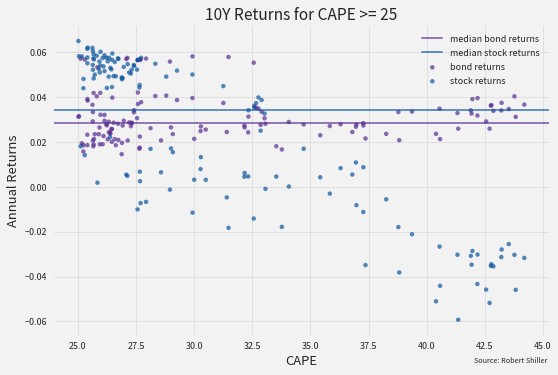

In [10]:
tdf = df_10y[df_10y['cape'] >= 25]
ax = tdf.plot.scatter('cape', 'gs10_returns', edgecolor='none', alpha=0.7, color=b_palette[0], label='bond returns', figsize=style_prefs.figure_medium_size)
ax.axhline(tdf['gs10_returns'].median(), alpha=0.7, color=b_palette[0], label='median bond returns')
tdf.plot.scatter('cape', 'returns', edgecolor='none', color=s_palette[0], alpha=0.7, label='stock returns', ax=ax)
ax.axhline(tdf['returns'].median(), alpha=0.7, color=s_palette[0], label='median stock returns')
ax.set_ylabel("Annual Returns")
ax.set_xlabel("CAPE")
ax.set_title("10Y Returns for CAPE >= 25")
ax.legend()
dsr.cite_source(ax)

On closer inspection, it looks like our model does not conform to reality at high levels of CAPE. When CAPE exceeds 25, median bond returns tend indeed to be higher than median stock returns. More generally, we can look at the difference between stock and bond returns and plot this as a function of CAPE.

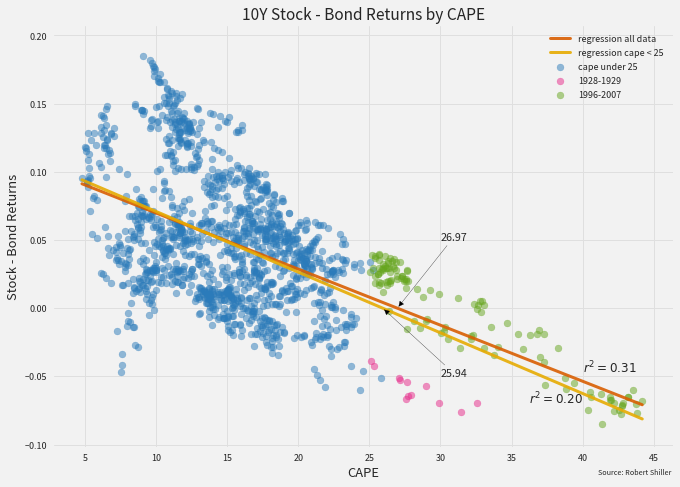

In [11]:
high_cape, under_25 = dsr.split_cape_threshold_years(df_10y, 25)

diff_ser = df_10y['returns'] - df_10y['gs10_returns']
df_10y['s_b_diff'] = diff_ser
under_25['s_b_diff'] = diff_ser

# Build a regression model over all data
lm_alldata = dsr.LinearModel('cape', 's_b_diff', df_10y, [cape_range[0], cape_range[-1]])
lm_alldata.fit_and_predict()

# Build a regression model over data where cape<25
lm_lt25 = dsr.LinearModel('cape', 's_b_diff', under_25, [cape_range[0], cape_range[-1]])
lm_lt25.fit_and_predict()

# Plot points
fig, ax = plt.subplots()
ax.scatter(df_10y.loc[under_25.index, 'cape'], diff_ser[under_25.index], alpha=0.5, color=s_palette[1], label='cape under 25')
for (i, (name, group_df)) in enumerate(high_cape.groupby('period')):
    if i < 2:
        plt.scatter(df_10y.loc[group_df.index, 'cape'], diff_ser[group_df.index], alpha=0.5, color=l_palette[2+i], label=name)
ax.set_ylabel("Stock - Bond Returns")
ax.set_xlabel("CAPE")

# Plot All Data Regression
ax.plot(lm_alldata.pred_range, lm_alldata.predictions, color=l_palette[0], alpha=0.9, lw=3.0, label="regression all data")
ax.text(40, -0.047, "$r^2={:.2f}$".format(lm_alldata.rsquared))
x_intercept = lm_alldata.x_intercept
ax.annotate("{:.2f}".format(x_intercept), xy=(x_intercept, 0), xytext=(30, 0.05), arrowprops=dict(facecolor='black', arrowstyle="-|>"),)

# Plot CAPE<25 Regression
ax.plot(lm_lt25.pred_range, lm_lt25.predictions, color=l_palette[1], alpha=0.9, lw=3.0, label='regression cape < 25')
ax.text(40, -0.07, "$r^2={:.2f}$".format(lm_lt25.rsquared_computed), ha='right')
x_intercept = lm_lt25.x_intercept
ax.annotate("{:.2f}".format(x_intercept), xy=(x_intercept, 0), xytext=(30, -0.05), arrowprops=dict(facecolor='black', arrowstyle="-|>"),)

ax.set_title("10Y Stock - Bond Returns by CAPE")
ax.legend()
dsr.cite_source(ax)

Performing a regression, we get a line that crosses the y-axis at `CAPE=26.97`, meaning that our regression model predicts that bonds should perform better than stocks for CAPE greater than this value. And if you, like me, are weary of giving too much weight the very few periods in which CAPE has been above 25, we can also we discard the data for `CAPE >= 25` and perform the same regression. Surprisingly (to me, at least), we get a very similar line, but this time with the x-intercept at `CAPE=25.94`. Maybe there is something to this CAPE 25 threshold...

So it looks like there is at least a weak relationship between CAPE and the relative attractiveness of stocks and bonds. For comparison, we can look at another variable like inflation. Does inflation play a role in returns?

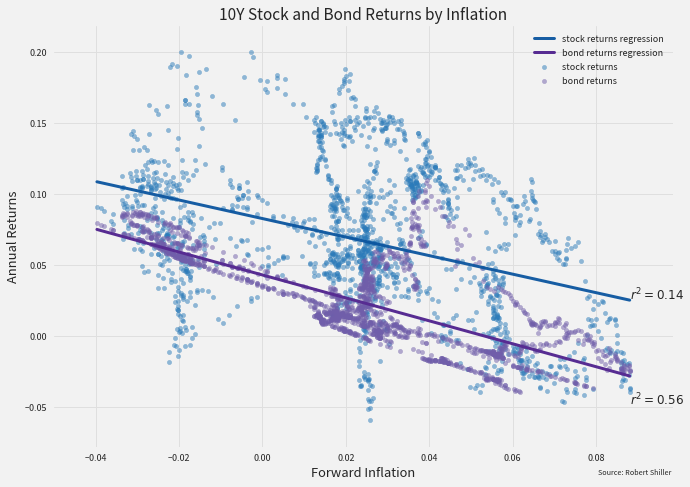

In [12]:
inflation_bounds = [df_10y['forward_inflation'].min(), df_10y['forward_inflation'].max()]

# Returns vs. Inflation
ax = df_10y.plot.scatter('forward_inflation', 'returns', alpha=0.5, color=s_palette[1], label='stock returns')
stocks_lm = dsr.LinearModel('forward_inflation', 'returns', df_10y, inflation_bounds).fit_and_predict()
ax.plot(inflation_bounds, stocks_lm.predictions, color=s_palette[0], alpha=0.95, lw=3.0, label='stock returns regression')
ax.text(inflation_bounds[1], stocks_lm.predictions[1], "$r^2={:.2f}$".format(stocks_lm.rsquared))

# GS10 vs. Inflation
df_10y.plot.scatter('forward_inflation', 'gs10_returns', alpha=0.5, color=b_palette[1], label='bond returns', ax=ax)
bonds_lm = dsr.LinearModel('forward_inflation', 'gs10_returns', df_10y, inflation_bounds).fit_and_predict()
ax.plot(inflation_bounds, bonds_lm.predictions, color=b_palette[0], alpha=1, lw=3.0, label='bond returns regression')
ax.text(inflation_bounds[1], bonds_lm.predictions[1]-0.02, "$r^2={:.2f}$".format(bonds_lm.rsquared))

ax.set_ylabel("Annual Returns")
ax.set_xlabel("Forward Inflation")
ax.set_title("10Y Stock and Bond Returns by Inflation")
ax.legend()
dsr.cite_source(ax)

Unsurprisingly, inflation does play a strong role in bond returns, but a much weaker one in stock returns. In fact, negative bond returns only occur at (forward) inflation levels of above 2%, whereas we see negative stock market returns with both high inflation and under deflation.

For deciding between stocks and bonds, it does look like CAPE is a solid tool to use for comparison and evaluation.

# 10-Year vs. 15 and 20-Year Returns

CAPE is based on stock price divided by a 10-year average earnings, and we can use it to predict 10-year forward returns. But we can also try to apply it to predict returns over other time horizons like 15 or 20-years.

We do not yet have the data to compute 20-year returns for the highest levels of CAPE, but still, we can see some tendencies as time horizons get longer. Though annualized returns may be worse, stocks generally produce better gross returns as time horizons get longer.

In [13]:
# Multiple Horizon Data
stocks_15y = s_cape.StockReturns(ie_data, 15)
stocks_20y = s_cape.StockReturns(ie_data, 20)
wr_15y = s_cape.WarrantedReturns(cape_10y, stocks_15y)
wr_20y = s_cape.WarrantedReturns(cape_10y, stocks_20y)
bond_15y = s_cape.BondHoldToMaturityReturns(ie_data, 15)
bond_20y = s_cape.BondHoldToMaturityReturns(ie_data, 20)
inflation_15y = s_cape.Inflation(ie_data, 15)
inflation_20y = s_cape.Inflation(ie_data, 20)
annualized_limits = [stocks_10y.df['returns'].append(stocks_15y.df['returns']).append(stocks_20y.df['returns']).min(),
                     stocks_10y.df['returns'].append(stocks_15y.df['returns']).append(stocks_20y.df['returns']).max()]
gross_limits = [stocks_10y.df['gross_returns'].append(stocks_15y.df['gross_returns']).append(stocks_20y.df['gross_returns']).min(),
                     stocks_10y.df['gross_returns'].append(stocks_15y.df['gross_returns']).append(stocks_20y.df['gross_returns']).max()]

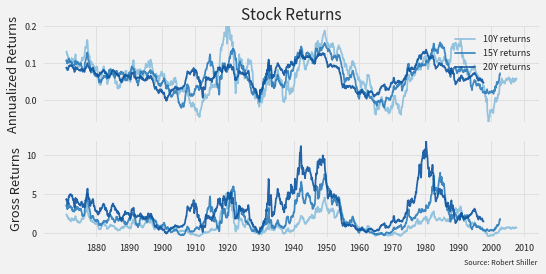

In [14]:
def plot_returns(ax, instr, col, color):
    ax.plot(instr[0].df.index, instr[0].df[col], color=color[3], alpha=0.9, label="10Y returns")
    ax.plot(instr[0].df.index, instr[1].df[col], color=color[1], alpha=0.9, label="15Y returns")
    ax.plot(instr[0].df.index, instr[2].df[col], color=color[0], alpha=0.9, label="20Y returns")
    ax.set_xticks(dsr.time_ticks())
    
fig, axs = plt.subplots(2, 1, figsize=style_prefs.figure_small_size)

ax = plt.subplot(2, 1, 1)
plot_returns(ax, [stocks_10y, stocks_15y, stocks_20y], 'returns', s_palette)
ax.xaxis.set_ticklabels([])
ax.set_ylabel("Annualized Returns")
ax.set_ylim(annualized_limits)
ax.set_title("Stock Returns")
ax.legend()

ax = plt.subplot(2, 1, 2)
plot_returns(ax, [stocks_10y, stocks_15y, stocks_20y], 'gross_returns', s_palette)
ax.set_ylabel("Gross Returns")
ax.set_ylim(gross_limits)
dsr.cite_source(ax)

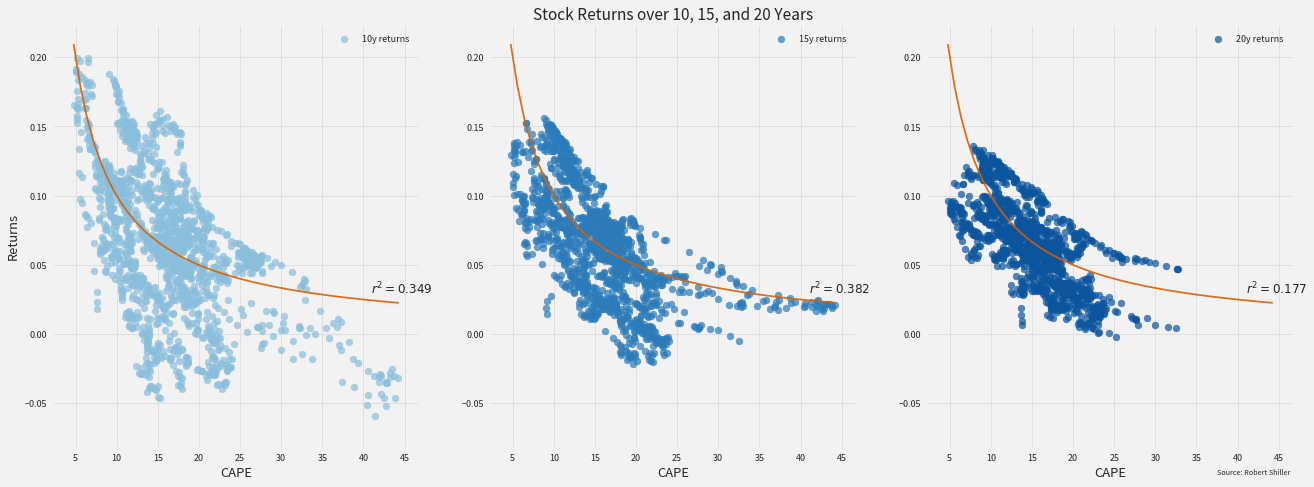

In [15]:
def plot_stocks(ax, stocks, wr, color, horizon):
    label = "{}y returns".format(horizon)
    ax.scatter(cape_10y.df['cape'], stocks.df['returns'], color=s_palette[color], alpha=0.7, label=label)    
    cape_range, curve = wr.warranted_returns_curve()
    ax.plot(cape_range, curve, color=l_palette[0],  alpha=0.9)
    
    ss_res = np.sum(np.power(wr.df['wr_error'], 2))
    ss_tot = np.sum(np.power(stocks.df['returns'] - stocks.df['returns'].mean(), 2))
    rsquared = 1 - (ss_res / ss_tot)
    ax.text(cape_range[-5], curve[-5]+0.005, "$r^2={:.3f}$".format(rsquared))

    ax.legend()
width, height = plt.rcParams["figure.figsize"]
fig, axs = plt.subplots(1, 3, figsize=(width*2, height))

ax = plt.subplot(1, 3, 1)
ax.set_ylabel("Returns")
ax.set_xlabel("CAPE")
plot_stocks(ax, stocks_10y, wr_10y, 3, "10")

ax = plt.subplot(1, 3, 2, sharey=ax, sharex=ax)
ax.set_title("Stock Returns over 10, 15, and 20 Years")
ax.set_xlabel("CAPE")
plot_stocks(ax, stocks_15y, wr_15y, 1, "15")

ax = plt.subplot(1, 3, 3, sharey=ax, sharex=ax)
plot_stocks(ax, stocks_20y, wr_20y, 0, "20")
ax.set_xlabel("CAPE")

dsr.cite_source(ax)

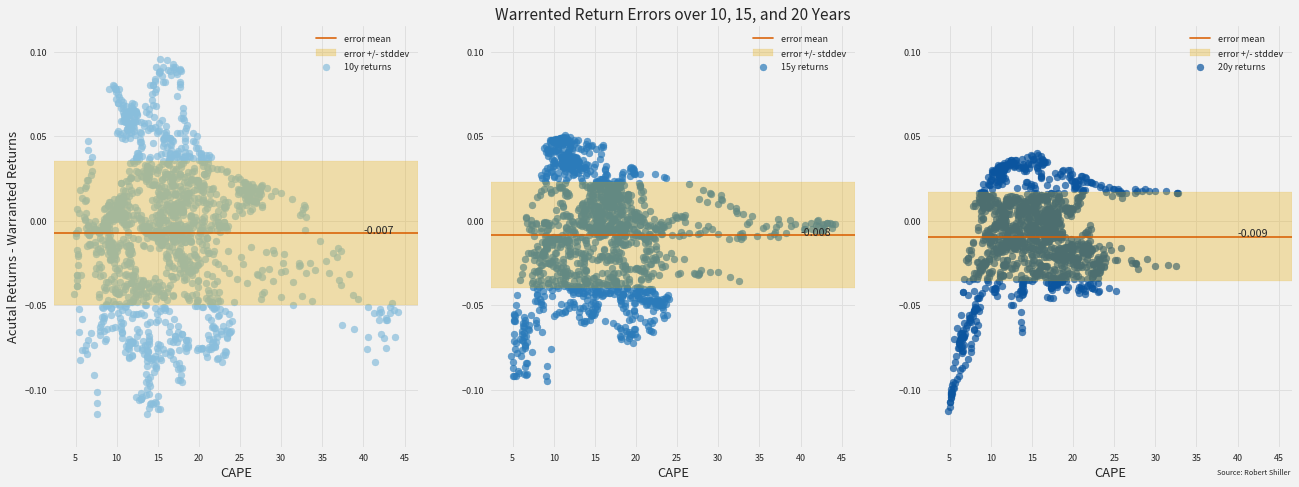

In [16]:
def plot_error(ax, stocks, wr, color, horizon):
    label = "{}y returns".format(horizon)
    ax.scatter(cape_10y.df['cape'], wr.df['wr_error'], color=s_palette[color], alpha=0.7, label=label)    
    error_mean = wr.df['wr_error'].mean()
    ax.axhline(error_mean, alpha=0.9, color=l_palette[0], label='error mean')
    error_stddev = wr.df['wr_error'].std()
    ax.axhspan(error_mean - error_stddev, error_mean + error_stddev, color=l_palette[1], alpha=0.3, label="error +/- stddev")
    ax.text(40, error_mean, "{:.3f}".format(error_mean))
    ax.legend()
    
width, height = plt.rcParams["figure.figsize"]
fig, axs = plt.subplots(1, 3, figsize=(width*2, height))    

ax = plt.subplot(1, 3, 1)
ax.set_ylabel("Acutal Returns - Warranted Returns")
ax.set_xlabel("CAPE")
plot_error(ax, stocks_10y, wr_10y, 3, "10")

ax = plt.subplot(1, 3, 2, sharey=ax, sharex=ax)
ax.set_title("Warrented Return Errors over 10, 15, and 20 Years")
ax.set_xlabel("CAPE")
plot_error(ax, stocks_15y, wr_15y, 1, "15")

ax = plt.subplot(1, 3, 3, sharey=ax, sharex=ax)
ax.set_xlabel("CAPE")
plot_error(ax, stocks_20y, wr_20y, 0, "20")

dsr.cite_source(ax)

The warranted-returns model seems to perform better at longer time horizons; the dispersion relative to the warranted returns curve gets smaller. (The $r^2$ value for the 20-year returns model is lower than for the 10 and 15-year models, but this is largely caused by the discrepancy in returns from CAPE levels below 7.5. This last occurred between WWI and WWII.)

## Loss Periods

Over most 10, 15, and 20-year periods, the stock market yields positive returns. One of the issues DeLong raises with CAPE is that there are periods in which CAPE is low, but the market returns over 10 years are nevertheless negative. And the same is true for 15-year returns over certain periods as well.

The reassuring news is that for periods in which 10 or 15-year returns are negative, staying in the market longer has eventually brought real returns back into positive territory. And in many cases, the returns even go back to near the warranted returns curve in later time horizons.

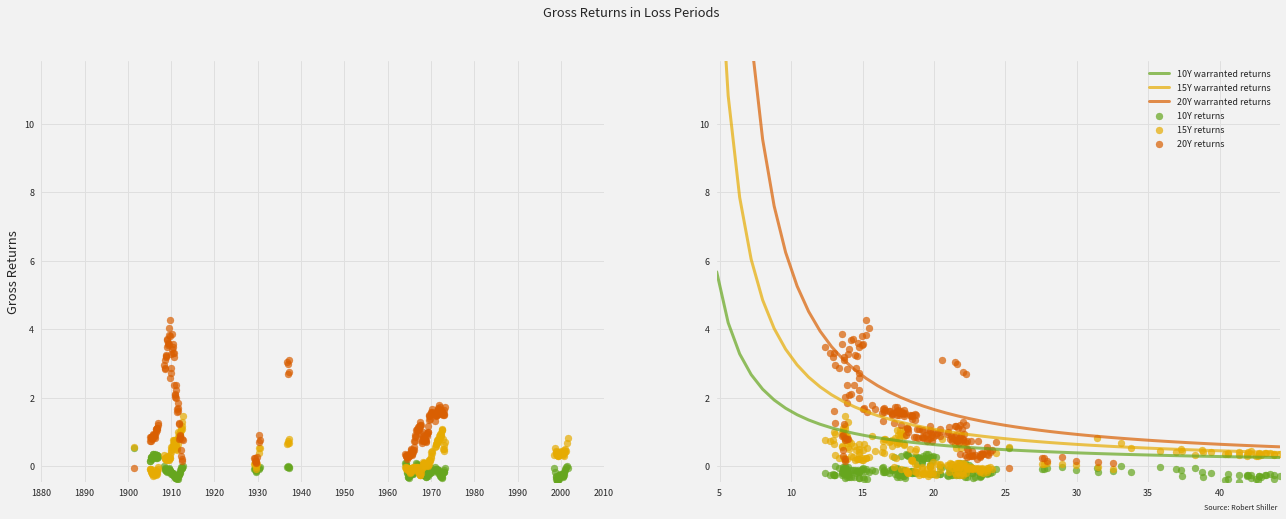

In [17]:
def plot_returns(ax, loc, horiz, col, color):
    for h, c, y in zip(horiz, color, [10, 15, 20]):
        ax.scatter(loc, h.df.loc[loc, col], color=c, alpha=0.7, label="{}Y returns".format(y))
    ax.set_xticks(dsr.time_ticks())
    ax.set_ylim(gross_limits)
    
def plot_returns_cape(ax, loc, cape, horiz, wr_horiz, col, color):
    for h, c, y in zip(horiz, color, [10, 15, 20]):
        ax.scatter(cape.df.loc[loc, 'cape'], h.df.loc[loc, col], color=c, alpha=0.7, label="{}Y returns".format(y))
    for w, c, y in zip(wr_horiz, color, [10, 15, 20]):
        cape_range, curve = w.gross_warranted_returns_curve()
        ax.plot(cape_range, curve, color=c,  alpha=0.7, lw=3, label='{}Y warranted returns'.format(y))
    ax.set_xlim([cape.df['cape'].min(), cape.df['cape'].max()])
    ax.set_ylim(gross_limits)

lp = dsr.loss_indices(stocks_10y.df, stocks_15y.df, stocks_20y.df)

colors = [l_palette[i] for i in [3, 1, 0]]
width, height = plt.rcParams["figure.figsize"]
fig, axs = plt.subplots(2, 2, figsize=(width*2, height))
ax = plt.subplot(1, 2, 1)
plot_returns(ax, lp, [stocks_10y, stocks_15y, stocks_20y], 'gross_returns', colors)
ax.set_ylabel("Gross Returns")

ax = plt.subplot(1, 2, 2)
plot_returns_cape(ax, lp, cape_10y, 
                  [stocks_10y, stocks_15y, stocks_20y], 
                  [wr_10y, wr_15y, wr_20y],
                  'gross_returns', colors)

ax.legend()

fig.suptitle("Gross Returns in Loss Periods")
dsr.cite_source(ax)

## Return Inversions

Though longer investment horizons typically see better gross returns, there are no guarantees. There have been several occasions in which  gross returns over shorter time horizons had better yields than longer time horizons. And this can happen anywhere in the CAPE range.

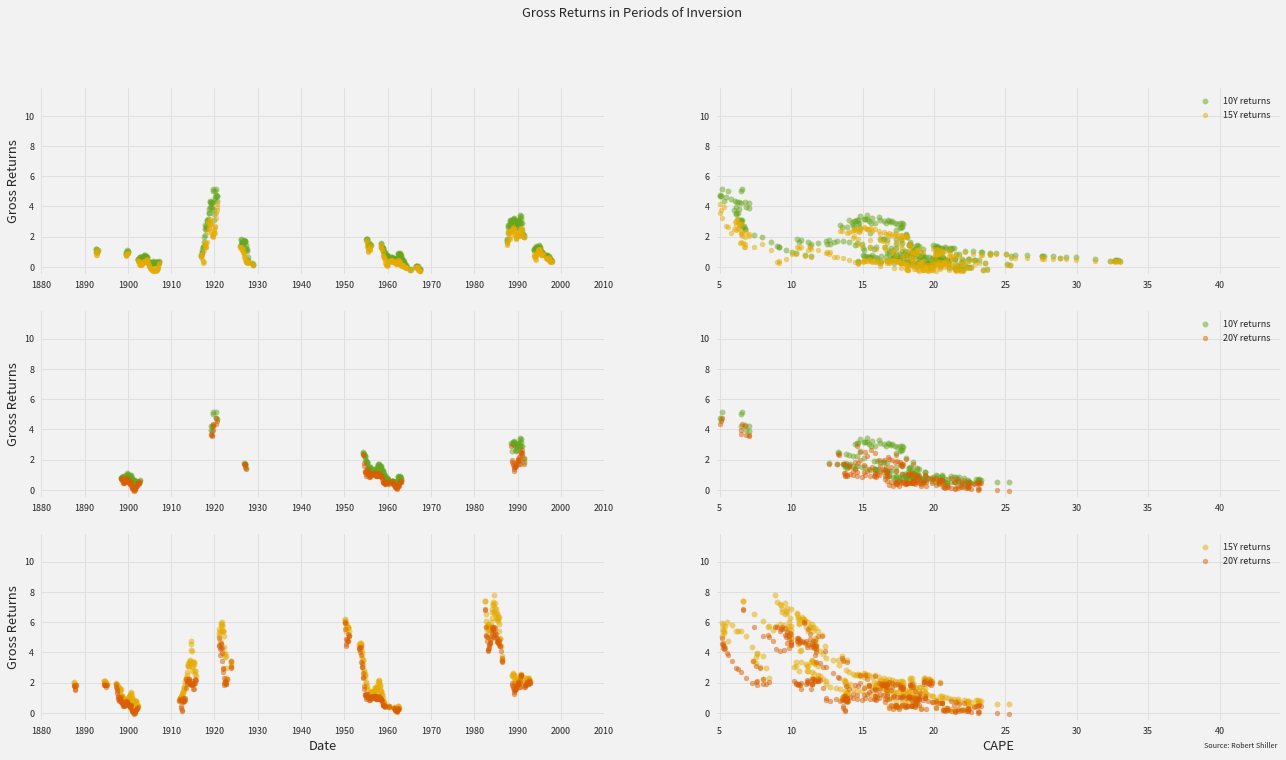

In [18]:
def plot_inversion_returns_time(ax, instr, color, horiz):
    col = 'gross_returns'
    loc = dsr.inversion_indices(instr[0].df, instr[1].df, col)
    ax.scatter(loc, instr[0].df.loc[loc, col], color=color[0], alpha=0.5, s=30, label="{}Y returns".format(horiz[0]))
    ax.scatter(loc, instr[1].df.loc[loc, col], color=color[1], alpha=0.5, s=25, label="{}Y returns".format(horiz[1]))
    ax.set_xticks(dsr.time_ticks())
    ax.set_ylim(gross_limits)
    
def plot_inversion_returns_cape(ax, cape, instr, color, horiz):
    col = 'gross_returns'
    loc = dsr.inversion_indices(instr[0].df, instr[1].df, col)
    ax.scatter(cape.df.loc[loc, 'cape'], instr[0].df.loc[loc, col], color=color[0], alpha=0.5, s=30, label="{}Y returns".format(horiz[0]))
    ax.scatter(cape.df.loc[loc, 'cape'], instr[1].df.loc[loc, col], color=color[1], alpha=0.5, s=25, label="{}Y returns".format(horiz[1]))
    ax.set_xlim([cape.df['cape'].min(), cape.df['cape'].max()])
    ax.set_ylim(gross_limits)

width, height = plt.rcParams["figure.figsize"]
fig, axs = plt.subplots(3, 2, figsize=(width*2, height*1.5))
ax = plt.subplot(3, 2, 1)
plot_inversion_returns_time(ax, [stocks_10y, stocks_15y], [l_palette[3], l_palette[1]], [10, 15])
ax.set_ylabel("Gross Returns")
ax = plt.subplot(3, 2, 2)
plot_inversion_returns_cape(ax, cape_10y, [stocks_10y, stocks_15y], [l_palette[3], l_palette[1]], [10, 15])
ax.legend()

ax = plt.subplot(3, 2, 3)
plot_inversion_returns_time(ax, [stocks_10y, stocks_20y], [l_palette[3], l_palette[0]], [10, 20])
ax.set_ylabel("Gross Returns")
ax = plt.subplot(3, 2, 4)
plot_inversion_returns_cape(ax, cape_10y, [stocks_10y, stocks_20y], [l_palette[3], l_palette[0]], [10, 20])
ax.legend()

ax = plt.subplot(3, 2, 5)
plot_inversion_returns_time(ax, [stocks_15y, stocks_20y], [l_palette[1], l_palette[0]], [15, 20])
ax.set_ylabel("Gross Returns")
ax.set_xlabel("Date")
ax = plt.subplot(3, 2, 6)
plot_inversion_returns_cape(ax, cape_10y, [stocks_15y, stocks_20y], [l_palette[1], l_palette[0]], [15, 20])
ax.set_xlabel("CAPE")
ax.legend()

fig.suptitle("Gross Returns in Periods of Inversion")

dsr.cite_source(ax)

## Waiting

In the above section, we looked at the the difference between investment time horizons from the same starting point. Though Shiller is a bit coy about giving direct investment advice, he does not come across as suggesting that if you invest in the market in a high-CAPE phase, you should prepare to stay in the market longer. Rather, he appears to suggest that you may want consider waiting a bit before investing in the market. 

So what happens if you, instead of investing right away, stuff the money in a mattress for a bit and then, after waiting 1, 2, or 3 years, drop it all in the market? First of all, the real value of the money in the mattress changes a bit due to inflation. But we can compensate for that and then compare, the 10-year returns on $1 vs. 9-year returns on the inflation-adjusted dollar one year later.

Doing this, we see that waiting is, in aggregate, a losing strategy. But there is a noticeable trend that, as CAPE levels go up, the relative value of waiting increases.

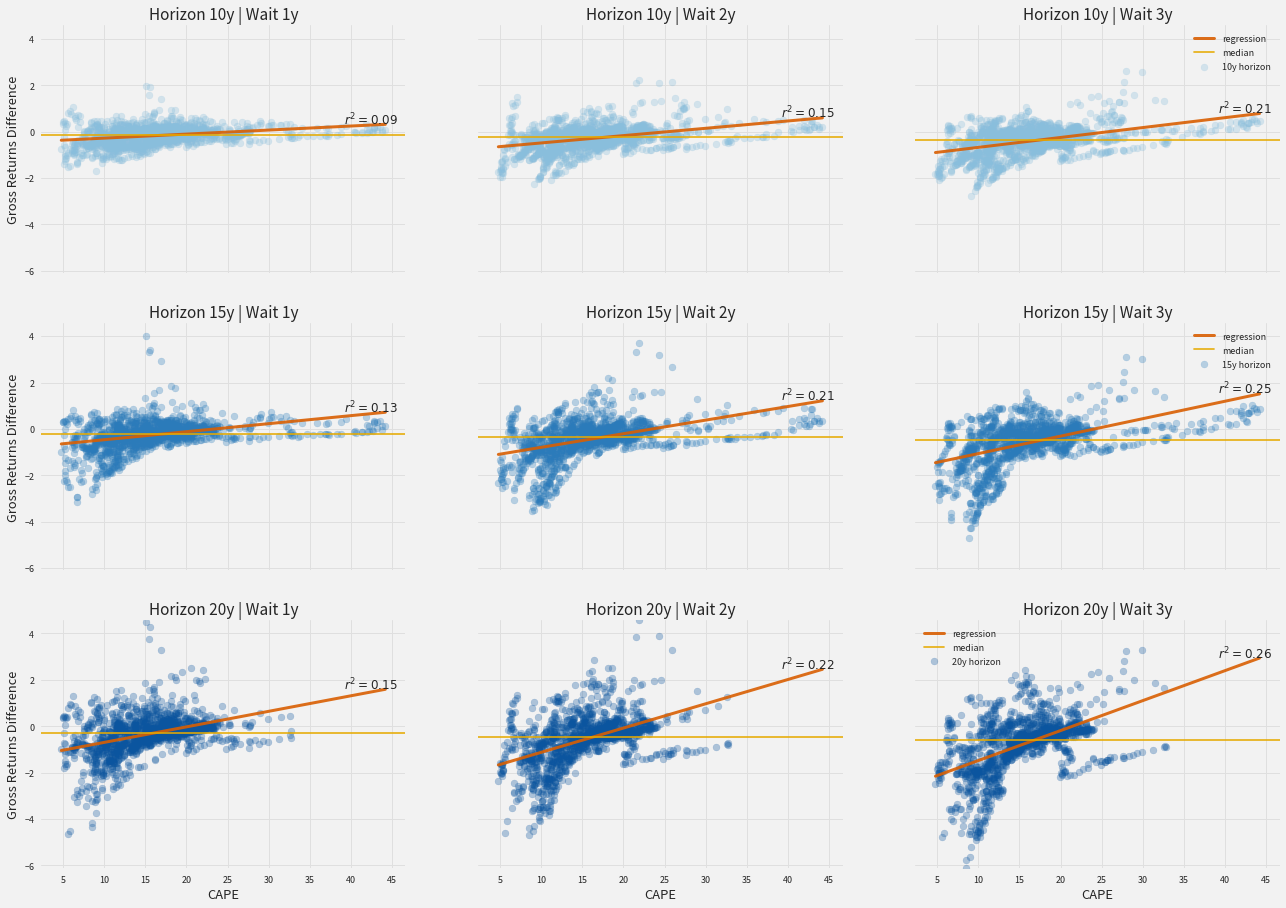

In [19]:
def plot_wait_row(axs, horizon, waits, cape_df, wait_df, color):
    for ax, wait in zip(axs, waits):
        ax.scatter(cape_df.cape, wait_df[wait], color=color, alpha=0.3, label="{}y horizon".format(horizon))
        
        ldf = pd.DataFrame({'diff': wait_df[wait], 'cape': cape_df.cape})
        lm = dsr.LinearModel('cape', 'diff', ldf.dropna(), [cape_range[0], cape_range[-1]]).fit_and_predict()
        ax.plot(lm.pred_range, lm.predictions, color=l_palette[0], alpha=0.9, lw=3.0, label="regression")
        ax.text(lm.pred_range[1]-5, lm.predictions[1], "$r^2={:.2f}$".format(lm.rsquared))
        
        ax.axhline(wait_df[wait].median(), color=l_palette[1], alpha=0.9, label="median")
        
        ax.set_title("Horizon {}y | Wait {}y".format(horizon, wait))
        ax.set_ylim(wait_returns.diff_limits)    
    axs[0].set_ylabel("Gross Returns Difference")
    axs[-1].legend()

wait_returns = s_cape.WaitingReturns(ie_data, [10, 15, 20], range(1, 4))

fig, axs = plt.subplots(len(wait_returns.horizons), len(wait_returns.waits), figsize=(width*2, height*2), sharex=True, sharey=True)
colors = [s_palette[i] for i in [3, 1, 0]]
for i, horizon in enumerate(wait_returns.horizons):
    wait_df = wait_returns.wait_dfs[i]
    ax_row = axs[i]
    plot_wait_row(ax_row, horizon, wait_returns.waits, cape_10y.df, wait_df, colors[i])
last_ax_row = ax_row
for i in range(3):
    last_ax_row[i].set_xlabel("CAPE")

# October 2017

And what about today, October 2017? Earlier this year, Robert Shiller was in the media arguing that the market is overpriced (e.g., http://businessinsider.com/robert-shiller-stock-market-overpriced-2017-3).

Past performance is not an indicator of future performance. Nonetheless, we can see what past performance at today's CAPE levels would yield. We have earnings data up to the end of Q2 2017 and using that, we can compute CAPE and try the following impossibly naïve model: for a current CAPE value (for which we do not yet have returns data), take the 19 closest values in the past and average these to get a prediction. This is of course not how machine learning should be done. You should estimate parameters, do cross validation, etc. Still, as a starting point, let's see what this gives us.

In [20]:
estimator = s_cape.CapeNeighborsEstimator(cape_10y)
predictor = estimator.fit(stocks_10y.df, 'gross_returns')
df_pred_10y = predictor.predict(19, stocks_10y.period_utils.annualized_returns, 'returns').join(cape_10y.df)

In [21]:
def plot_predictions(ax, cape_range, wr, cape_df, df, pred_df, column='returns', arrow_start = -18, num_labels=3):
    df = df.join(cape_df['cape'])
    df.plot.scatter('cape', column, alpha=0.7, color=s_palette[3], ax=ax, 
                    label="up to {}".format(dsr.latest_index_label(df[column].dropna())))
    pred_df.plot.scatter('cape', column, alpha=0.7, color=l_palette[2], ax=ax, label="predictions")
    if column == 'returns':
        plt.plot(cape_range, wr, color=l_palette[0],  alpha=0.9)
    cape_col = np.where(pred_df.columns=='cape')[0][0]
    ret_col = np.where(pred_df.columns==column)[0][0]
    plt.quiver(pred_df.iloc[arrow_start:-1,cape_col], 
               pred_df.iloc[arrow_start:-1,ret_col], 
               pred_df.iloc[arrow_start+1:,cape_col].values-pred_df.iloc[arrow_start:-1,cape_col].values, 
               pred_df.iloc[arrow_start+1:,ret_col].values-pred_df.iloc[arrow_start:-1,ret_col].values,
               scale_units='xy', angles='xy', scale=1, headwidth=2, headlength=4.5,
               color=l_palette[2],  alpha=0.6)
    for i in range(num_labels):
        pos = int(-1+(i*(arrow_start/num_labels)))
        ax.text(pred_df.iloc[pos,cape_col], pred_df.iloc[pos,ret_col] + 0.005, "{}".format(pred_df.index[pos].strftime("%Y-%m")))
    if column == 'returns':
        ax.set_ylim(annualized_limits)
    # Force legend to be added by the caller
    ax.legend_.remove()

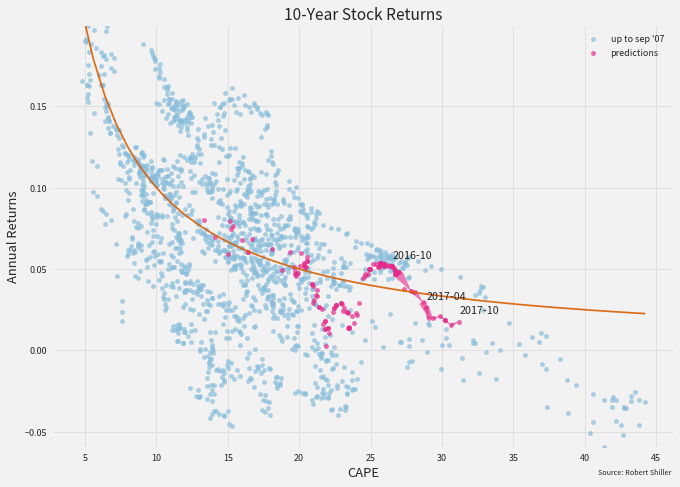

In [22]:
cape_range, wr = wr_10y.warranted_returns_curve()
fig, ax = plt.subplots()
plot_predictions(ax, cape_range, wr, cape_10y.df, stocks_10y.df, df_pred_10y)
ax.set_ylabel("Annual Returns")
ax.set_xlabel("CAPE")
ax.set_title("10-Year Stock Returns")
ax.legend()
dsr.cite_source(ax)

Based on previous performance at comparable CAPE levels, our model predicts 10-year returns that are less then what the warranted-returns model predicts. The predicted returns are positive, though.

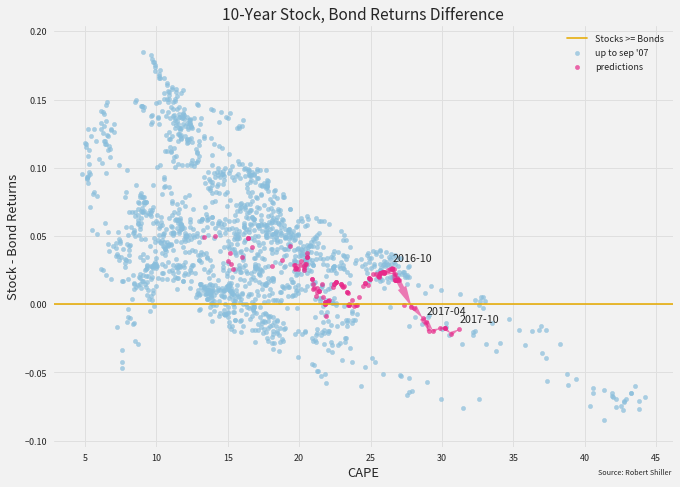

In [23]:
diff_ser = df_10y['returns'] - df_10y['gs10_returns']
diff_df = pd.DataFrame(diff_ser, columns=['stocks_bonds_diff'])
predictor = estimator.fit(diff_df, 'stocks_bonds_diff')
df_pred_diff_10y = predictor.predict(19).join(cape_10y.df)

fig, ax = plt.subplots()
plot_predictions(ax, cape_range, wr, cape_10y.df, diff_df, df_pred_diff_10y, 'stocks_bonds_diff')
ax.axhline(0, color=l_palette[1], alpha=0.9, label="Stocks >= Bonds")
ax.set_ylabel("Stock - Bond Returns")
ax.set_xlabel("CAPE")
ax.set_title("10-Year Stock, Bond Returns Difference")
ax.legend()
dsr.cite_source(ax)

When comparing stocks to bonds, our model thinks that bonds will outperform stocks over the next 10 years.

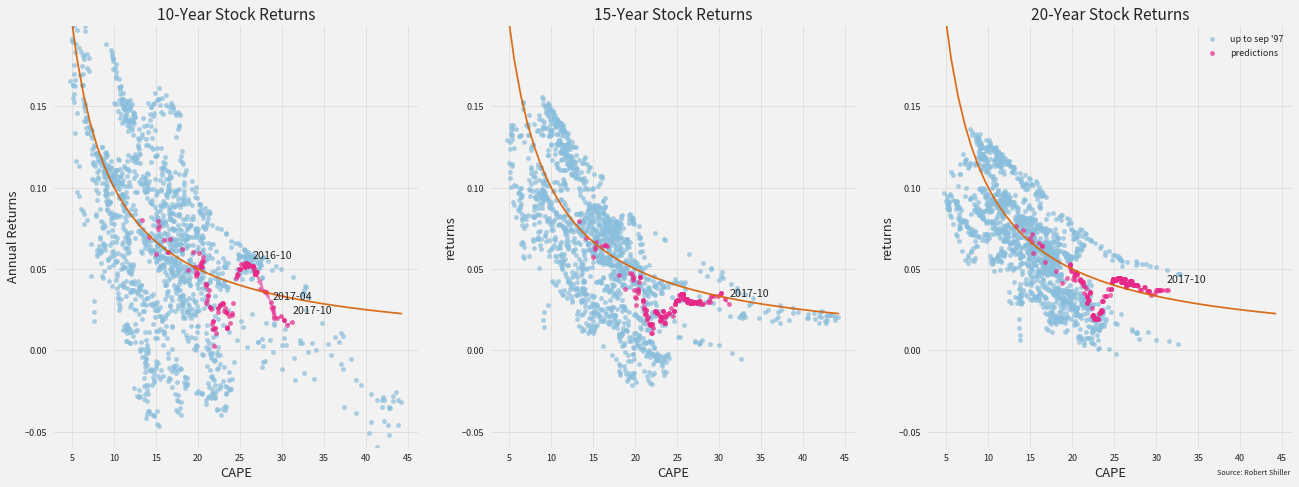

In [24]:
df_pred_15y = estimator.fit(stocks_15y.df, 'gross_returns').predict(19, stocks_15y.period_utils.annualized_returns, 'returns').join(cape_10y.df)
df_pred_20y = estimator.fit(stocks_20y.df, 'gross_returns').predict(19, stocks_20y.period_utils.annualized_returns, 'returns').join(cape_10y.df)

# Remove estimates beyond cape > 32 -- we don't have good data to make predictions
df_pred_20y.loc[df_pred_20y.cape > 32, 'returns'] = np.nan

cape_range, wr = wr_10y.warranted_returns_curve()
fig, axs = plt.subplots(1, 3, figsize=(width*2, height))

ax = plt.subplot(1, 3, 1)
plot_predictions(ax, cape_range, wr, cape_10y.df, stocks_10y.df, df_pred_10y)
ax.set_ylabel("Annual Returns")
ax.set_xlabel("CAPE")
ax.set_title("10-Year Stock Returns")

ax = plt.subplot(1, 3, 2)
plot_predictions(ax, cape_range, wr, cape_10y.df, stocks_15y.df, df_pred_15y, num_labels=1)
ax.set_xlabel("CAPE")
ax.set_title("15-Year Stock Returns")

ax = plt.subplot(1, 3, 3)
plot_predictions(ax, cape_range, wr, cape_10y.df, stocks_20y.df, df_pred_20y, num_labels=1)
ax.set_xlabel("CAPE")
ax.set_title("20-Year Stock Returns")
ax.legend()

dsr.cite_source(ax)

And when looking at time horizons beyond 10 years, our model predicts that returns will converge to the warranted returns at the current level of CAPE.

As I said earlier, I do not know anything about markets or investing, I just like exploring data. I'm not in a position to evaluate whether these predictions make sense at all, but they are what comes out of this simple model that builds on DeLong and Shiller's framework. I cannot offer any guidelines on how you should appraise this information.

# Conclusion and Epilogue

The basic CAPE + Warranted Returns model explored here is clearly a gross oversimplification. It is my attempt to understand a discussion between Robert Shiller and Brad DeLong, but it leaves open many questions that would need to be investigated in a more comprehensive analysis. For example:

* Is 10-years the best time frame for cyclically adjusting earnings? Is it objectively better than 11 years? Or 9.5 years?
* Compared to buy and hold, do mixed strategies perform better? E.g., buying bonds in high-CAPE periods and then selling to buy stocks as CAPE goes down?
* [Is there a secular trend in CAPE that needs to be corrected for](http://marginalrevolution.com/marginalrevolution/2014/08/from-the-comments-on-bob-shiller-and-cape.html)?

Nonetheless, basic models can be useful as a tool for understanding, and for me as a outsider to the world of finance, this one does provide quite a bit of insight.

I think it offers *me* some guidance for how I want to invest *my* money, but I read it as suggesting very different strategies depending on investment priorities. Anyway, I'm certainly not confident enough in my understanding to give others anything resembling investment advice, and, honestly, I put this exploration together for my 21-year-old self as much as for anyone else.

The hidden irony here is that the motivation for finally investigating questions that had been bothering me for 20 years came from Brad DeLong's post. He provided the first interpretation of P/E ratios that I could understand. Brad DeLong's office is in Evans Hall, a building I spent time in almost every day for four years. If I had then deviated from my quotidian routine by a few floors, I might have been able to learn what I needed to know to answer my investment questions when they first came up, and not just 20 years later.

I take this as a reminder to venture out a little bit and talk to people whose offices are a few floors above or below mine. This is advice I would not hesitate to give anyone.

October 19, 2017

_Zürich, Switzerland_